In [1]:
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = 1000

start_time = 1676012207000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds
step = 60000 * 15 # 15min

In [4]:
data = json.dumps({'method':'SUBSCRIBE','params':[symbol + '@kline_' + interval],'id':1})
df = pd.DataFrame()

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    global df
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        df = pd.concat([df, out], axis = 0)
    
    return df

In [6]:
df = get_historical(symbol, interval, start_time, end_time, step)

df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
df = df.astype(convert_dict)

df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit = 'ms')
df['Close_Time'] = df['Close_Time'] + pd.Timedelta(hours=timezone)

df = df.reset_index(drop=True)

rawdf = df

print(df)


                       Close_Time     Open    Close     High      Low  \
0   2023-02-10 15:14:59.999000064  1548.44  1546.07  1549.52  1544.53   
1   2023-02-10 15:29:59.999000064  1546.06  1545.52  1548.87  1543.47   
2   2023-02-10 15:44:59.999000064  1545.52  1550.52  1550.86  1545.01   
3   2023-02-10 15:59:59.999000064  1550.53  1551.70  1552.88  1549.45   
4   2023-02-10 16:14:59.999000064  1551.70  1552.55  1554.46  1549.71   
..                            ...      ...      ...      ...      ...   
481 2023-02-15 15:29:59.999000064  1550.75  1550.72  1551.22  1550.35   
482 2023-02-15 15:44:59.999000064  1550.72  1549.11  1550.85  1547.09   
483 2023-02-15 15:59:59.999000064  1549.12  1547.56  1549.19  1544.65   
484 2023-02-15 16:14:59.999000064  1547.56  1546.50  1548.99  1545.12   
485 2023-02-15 16:29:59.999000064  1546.49  1547.40  1547.74  1545.69   

        Volume  
0    3583.2456  
1    3176.1551  
2    2604.4426  
3    3470.7757  
4    5696.1407  
..         ...  
481 

In [7]:
df = rawdf

In [8]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [9]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi
0,2023-02-10 15:14:59.999000064,1548.44,1546.07,1549.52,1544.53,3583.2456,NaN,NaN,NaN,NaN,NaN
1,2023-02-10 15:29:59.999000064,1546.06,1545.52,1548.87,1543.47,3176.1551,NaN,NaN,NaN,NaN,NaN
2,2023-02-10 15:44:59.999000064,1545.52,1550.52,1550.86,1545.01,2604.4426,NaN,NaN,NaN,NaN,NaN
3,2023-02-10 15:59:59.999000064,1550.53,1551.70,1552.88,1549.45,3470.7757,NaN,NaN,NaN,NaN,NaN
4,2023-02-10 16:14:59.999000064,1551.70,1552.55,1554.46,1549.71,5696.1407,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
481,2023-02-15 15:29:59.999000064,1550.75,1550.72,1551.22,1550.35,1519.9726,1549.232667,1552.456718,1549.232667,1546.008616,53.176155
482,2023-02-15 15:44:59.999000064,1550.72,1549.11,1550.85,1547.09,2438.3659,1549.185333,1552.373301,1549.185333,1545.997365,48.272922
483,2023-02-15 15:59:59.999000064,1549.12,1547.56,1549.19,1544.65,3376.0392,1549.022667,1552.022191,1549.022667,1546.023143,44.060734
484,2023-02-15 16:14:59.999000064,1547.56,1546.50,1548.99,1545.12,2742.9688,1548.937333,1552.070438,1548.937333,1545.804229,41.400219


In [10]:
def conditions(df):
    # 進場條件
    # 下影線 大於 實體Ｋ 大於 上影線
    # 收盤 小於 布林下

    for index, row in df.iterrows():
        # red candle
        df['c1_1'] = (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # green candle
        df['c1_2'] = (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        df['c2'] = df['Close'] < df['bb_l']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1_1 & df.c1_2 & df.c2 , 'signal'] = True



    # 下根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy
0,2023-02-10 15:14:59.999000064,1548.44,1546.07,1549.52,1544.53,3583.2456,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
1,2023-02-10 15:29:59.999000064,1546.06,1545.52,1548.87,1543.47,3176.1551,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
2,2023-02-10 15:44:59.999000064,1545.52,1550.52,1550.86,1545.01,2604.4426,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
3,2023-02-10 15:59:59.999000064,1550.53,1551.70,1552.88,1549.45,3470.7757,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2023-02-10 16:14:59.999000064,1551.70,1552.55,1554.46,1549.71,5696.1407,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2023-02-15 15:29:59.999000064,1550.75,1550.72,1551.22,1550.35,1519.9726,1549.232667,1552.456718,1549.232667,1546.008616,53.176155,False,False,False,False,False
482,2023-02-15 15:44:59.999000064,1550.72,1549.11,1550.85,1547.09,2438.3659,1549.185333,1552.373301,1549.185333,1545.997365,48.272922,True,True,False,False,False
483,2023-02-15 15:59:59.999000064,1549.12,1547.56,1549.19,1544.65,3376.0392,1549.022667,1552.022191,1549.022667,1546.023143,44.060734,True,True,False,False,False
484,2023-02-15 16:14:59.999000064,1547.56,1546.50,1548.99,1545.12,2742.9688,1548.937333,1552.070438,1548.937333,1545.804229,41.400219,False,False,False,False,False


In [12]:
buydf = conditions(df)

# 進出場
in_position = False
stop_loss = np.nan
for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根k線收盤價進場)
        # set stop loss (前一根k線低點停損)
        # 進場
    if buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    if in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    if buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)
# df.to_csv('buydf.csv')


                       Close_Time     Open    Close     High      Low  \
35  2023-02-10 23:59:59.999000064  1525.90  1522.36  1525.90  1506.00   
36  2023-02-11 00:14:59.999000064  1522.35  1526.56  1534.00  1520.61   
39  2023-02-11 00:59:59.999000064  1519.19  1519.78  1523.85  1514.62   
40  2023-02-11 01:14:59.999000064  1519.77  1521.01  1524.12  1519.18   
58  2023-02-11 05:44:59.999000064  1520.12  1500.97  1521.51  1490.00   
142 2023-02-12 02:44:59.999000064  1515.52  1513.20  1516.07  1505.00   
143 2023-02-12 02:59:59.999000064  1513.20  1514.77  1516.46  1512.09   
154 2023-02-12 05:44:59.999000064  1521.77  1525.95  1526.39  1521.09   
215 2023-02-12 20:59:59.999000064  1527.23  1525.58  1529.46  1521.12   
216 2023-02-12 21:14:59.999000064  1525.57  1527.39  1528.05  1524.03   
218 2023-02-12 21:44:59.999000064  1524.48  1524.19  1525.67  1521.43   
219 2023-02-12 21:59:59.999000064  1524.19  1526.26  1527.00  1524.18   
225 2023-02-12 23:29:59.999000064  1535.46  1532.86

In [16]:
# 部位回測
posdf = buydf
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]


pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
#                 if i == index - 1:
#                     pos.at[index, 'size'] = -current_pos
#                 else:
#                     continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

    
        
print(pos)
pos.to_csv('pos.csv')

# 損益
leverage = 10
ttl_profit = -pos.amt.sum()


# 計算進場最大部位
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)
        
print(ttl_profit, max_entry, profit_per)



                      Close_Time     Open    Close     High      Low  \
0  2023-02-11 00:14:59.999000064  1522.35  1526.56  1534.00  1520.61   
1  2023-02-11 01:14:59.999000064  1519.77  1521.01  1524.12  1519.18   
2  2023-02-11 05:44:59.999000064  1520.12  1500.97  1521.51  1490.00   
3  2023-02-12 02:59:59.999000064  1513.20  1514.77  1516.46  1512.09   
4  2023-02-12 05:44:59.999000064  1521.77  1525.95  1526.39  1521.09   
5  2023-02-12 21:14:59.999000064  1525.57  1527.39  1528.05  1524.03   
6  2023-02-12 21:59:59.999000064  1524.19  1526.26  1527.00  1524.18   
7  2023-02-12 23:29:59.999000064  1535.46  1532.86  1541.00  1532.86   
8  2023-02-13 06:29:59.999000064  1502.65  1510.03  1512.15  1498.44   
9  2023-02-13 15:29:59.999000064  1520.74  1523.90  1526.10  1520.43   
10 2023-02-13 17:59:59.999000064  1484.21  1482.36  1492.51  1481.72   
11 2023-02-13 18:44:59.999000064  1474.80  1480.80  1480.90  1474.36   
12 2023-02-14 02:59:59.999000064  1484.71  1488.96  1493.91  148

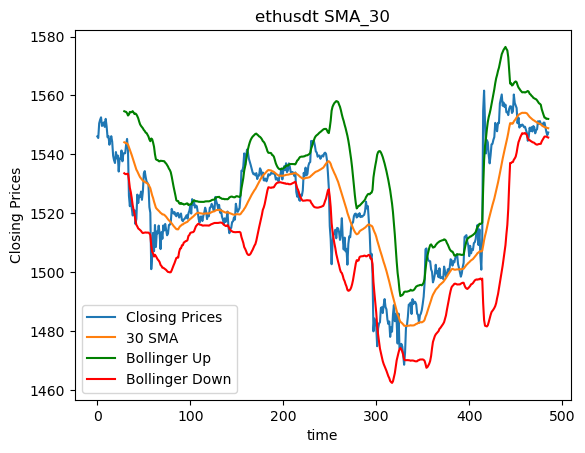

In [14]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()